# Complaints Analysis

## Imports

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import re
import seaborn as sns
import spacy
import string
import pprint
from wordcloud import WordCloud

In [2]:
nlp = spacy.load('en_core_web_sm')

In [3]:
PARENT_DIR = os.getcwd().rsplit("\\", maxsplit=1)[0]
DATASET_DIR = os.path.join(PARENT_DIR, "Datasets")

## Utilities

In [4]:
plt.rcParams["axes.spines.left"] = False
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.grid.axis"] = "y"
plt.rcParams["grid.alpha"] = "0.2"
plt.rcParams["grid.linestyle"] = "-."

In [5]:
def get_random_row(df : pd.DataFrame):
    rand_row = df.sample().iloc[0]
    print("ODINO:", rand_row["ODINO"])
    pprint.pprint(f"FAILDATE: {rand_row['FAILDATE']}")
    pprint.pprint(f"CITY: {rand_row['CITY']}")
    pprint.pprint(f"STATE: {rand_row['STATE']}")
    pprint.pprint(f"COMPDESC: {rand_row['COMPDESC']}")
    pprint.pprint(f"CDESCR: {rand_row['CDESCR']}")

In [6]:
def find_columns_defining_uniqueness(df : pd.DataFrame, duplicates_allowed=0,
                                    uniqueness_column="ODINO"):
    '''
        Find columns that defines a dataframe's uniqueness
        based on duplicate threshold requirements.

        df : DataFrame
        duplicates_allowed : how many ODINOs we want in our final dataset
        find_columns_defining_uniqueness(df_complaints, duplicates_allowed=50)
    '''
    prev_length = -1
    columns_defining_uniqueness = [uniqueness_column]
    while len(df) > 0 and len(df[uniqueness_column].unique()) > duplicates_allowed:
        # Find column with max unique counts that's not already selected
        unique_counts_per_odino = df.groupby(uniqueness_column).nunique().sum(axis=0).sort_values(ascending=False)
        max_unique_count = -1
        max_unique_count_index = -1
        for i, column in enumerate(unique_counts_per_odino.index):
            if column in columns_defining_uniqueness:
                continue
            else:
                max_unique_count = unique_counts_per_odino.loc[column]
                max_unique_count_index = i
                break
        
        if max_unique_count == -1:
            break

        if max_unique_count > len(df[uniqueness_column].unique()):
            columns_defining_uniqueness.append(unique_counts_per_odino.index[max_unique_count_index])
            df = df.loc[df.duplicated(subset=columns_defining_uniqueness, keep=False)]
        else:
            # No more column additions brings value
            break
    return columns_defining_uniqueness



In [7]:
def plot_distrib(df: pd.DataFrame, column_name: str,
                bins=None):
    '''
      Plot distribution on histogram
      :param df: polars dataframe
      :param column_name: column name to plot distribution of
      :param bins: number of bins to use
    '''
    fig, ax = plt.subplots()
    if bins is None:
      ## Assume values ar from range 1 to num_unique if bins are not specified
      num_unique = len(df[column_name].unique())
      bins = [i+1 for i in range(num_unique+1)]

    _, _, patches = ax.hist(x=df[column_name], align='left',
                bins=bins,
                rwidth=0.8)
    _ = ax.set_title(f"Distribution of {column_name}")
    _ = ax.set_ylabel("Number of Reviews")
    _ = ax.set_xlabel(column_name)
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
    ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
    ax.xaxis.set_major_locator(ticker.FixedLocator(bins[:-1]))
    totals = sum(ax.containers[0].datavalues)
    max_bar_height = max([patch.get_height() for patch in patches])
    slight_padding = max_bar_height * 0.01
    for i, patch in enumerate(patches):
      bar_height = patch.get_height()
      proportion_of_max_height = bar_height / max_bar_height
      if proportion_of_max_height < 0.05:
        # Place the label above the bar
        ax.text(patch.get_x() + patch.get_width() / 2, bar_height + slight_padding, f'{bar_height/totals*100:.2f}%',
                ha='center', va='bottom', color='black')
      else:
        # Place the label inside the bar
        ax.text(patch.get_x() + patch.get_width() / 2, bar_height - slight_padding, f'{bar_height/totals*100:.2f}%',
                ha='center', va='top', color='white')
    # ax.bar_label(ax.containers[0], color="white",
    #              padding=-15,
    #              labels=[f"{x/totals * 100:.2f}%"
    #                      if not np.isclose(x, 0) else ""
    #                      for x in ax.containers[0].datavalues])
    return fig, ax

def generate_word_frequencies_from_column(df, column):
    # Find all words in the column
    df = df.drop_duplicates(subset=[column])
    all_words = df[column].str.findall("\\b\\w\\w+\\b").explode(column)
    all_words = all_words.str.lower()

    # Get word counts. We have column in column string for word and column 'count' for frequency 
    word_frequencies = all_words.value_counts().reset_index()

    # Remove stopwords and words which do not contain letters (ex. 2016, 2017, 2018)
    uninterested_words_filter = (
        (word_frequencies[column].isin(nlp.Defaults.stop_words)) |
        ~(word_frequencies[column].str.contains("[a-zA-Z]"))
    )
    word_frequencies = word_frequencies.loc[
        ~uninterested_words_filter
    ]
    escaped_puncs = re.escape(string.punctuation)
    # There should be no punctuations present in any of the words
    assert len(
        word_frequencies[word_frequencies[column].str.contains('|'.join(escaped_puncs.split()))]
    ) == 0, \
    "There should be no punctuations in the analyzed words"
    return word_frequencies.set_index(column)


## Load Complaints Dataset

In [8]:
df_complaints = pd.read_csv(f"{DATASET_DIR}/COMPLAINTS_RECEIVED_2020-2024/COMPLAINTS_RECEIVED_2020-2024.txt", sep='\t', header=None, index_col=0)
df_complaints.columns = ['ODINO', 'MFR_NAME', 'MAKETXT', 'MODELTXT', 'YEARTXT', 'CRASH', 'FAILDATE', 'FIRE', 'INJURED', 'DEATHS', 'COMPDESC', 'CITY', 'STATE', 'VIN', 'DATEA', 'LDATE', 'MILES', 'OCCURENCES', 'CDESCR', 'CMPL_TYPE', 'POLICE_RPT_YN', 'PURCH_DT', 'ORIG_OWNER_YN', 'ANTI_BRAKES_YN', 'CRUISE_CONT_YN', 'NUM_CYLS', 'DRIVE_TRAIN', 'FUEL_SYS', 'FUEL_TYPE',
              'TRANS_TYPE', 'VEH_SPEED', 'DOT', 'TIRE_SIZE', 'LOC_OF_TIRE', 'TIRE_FAIL_TYPE', 'ORIG_EQUIP_YN', 'MANUF_DT', 'SEAT_TYPE', 'RESTRAINT_TYPE', 'DEALER_NAME', 'DEALER_TEL', 'DEALER_CITY', 'DEALER_STATE', 'DEALER_ZIP', 'PROD_TYPE', 'REPAIRED_YN', 'MEDICAL_ATTN', 'VEHICLES_TOWED_YN']

C:\Users\harri\AppData\Local\Temp\ipykernel_55784\1935432797.py:1: DtypeWarning: Columns (27,28,29,30,33,38,41,44) have mixed types. Specify dtype option on import or set low_memory=False.
  df_complaints = pd.read_csv(f"{DATASET_DIR}/COMPLAINTS_RECEIVED_2020-2024/COMPLAINTS_RECEIVED_2020-2024.txt", sep='\t', header=None, index_col=0)


## Preprocessing

In [9]:
# Lowercase strings for analysis
for column in df_complaints.columns:
    if column in ["CDESCR"]:
        df_complaints[column] = df_complaints[column].str.lower()

# Fill None with empty strings and replace spaces
for column in df_complaints.columns:
    if df_complaints[column].dtype == object:
        df_complaints[column] = df_complaints[column].fillna("").str.replace("\s+", " ", regex=True)

df_complaints["MMYTXT"] = (
    df_complaints["MAKETXT"] + " " + df_complaints["MODELTXT"] + " " + df_complaints["YEARTXT"].astype(str).fillna("")
)

## Descriptive Summary

In [10]:
df_complaints.columns

Index(['ODINO', 'MFR_NAME', 'MAKETXT', 'MODELTXT', 'YEARTXT', 'CRASH',
       'FAILDATE', 'FIRE', 'INJURED', 'DEATHS', 'COMPDESC', 'CITY', 'STATE',
       'VIN', 'DATEA', 'LDATE', 'MILES', 'OCCURENCES', 'CDESCR', 'CMPL_TYPE',
       'POLICE_RPT_YN', 'PURCH_DT', 'ORIG_OWNER_YN', 'ANTI_BRAKES_YN',
       'CRUISE_CONT_YN', 'NUM_CYLS', 'DRIVE_TRAIN', 'FUEL_SYS', 'FUEL_TYPE',
       'TRANS_TYPE', 'VEH_SPEED', 'DOT', 'TIRE_SIZE', 'LOC_OF_TIRE',
       'TIRE_FAIL_TYPE', 'ORIG_EQUIP_YN', 'MANUF_DT', 'SEAT_TYPE',
       'RESTRAINT_TYPE', 'DEALER_NAME', 'DEALER_TEL', 'DEALER_CITY',
       'DEALER_STATE', 'DEALER_ZIP', 'PROD_TYPE', 'REPAIRED_YN',
       'MEDICAL_ATTN', 'VEHICLES_TOWED_YN', 'MMYTXT'],
      dtype='object')

In [11]:
df_complaints.info()

<class 'pandas.core.frame.DataFrame'>
Index: 418344 entries, 1633298 to 2051719
Data columns (total 49 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   ODINO              418344 non-null  int64  
 1   MFR_NAME           418344 non-null  object 
 2   MAKETXT            418344 non-null  object 
 3   MODELTXT           418344 non-null  object 
 4   YEARTXT            418337 non-null  float64
 5   CRASH              418344 non-null  object 
 6   FAILDATE           418344 non-null  int64  
 7   FIRE               418344 non-null  object 
 8   INJURED            418344 non-null  int64  
 9   DEATHS             418344 non-null  int64  
 10  COMPDESC           418344 non-null  object 
 11  CITY               418344 non-null  object 
 12  STATE              418344 non-null  object 
 13  VIN                418344 non-null  object 
 14  DATEA              418344 non-null  int64  
 15  LDATE              418344 non-null  int64  
 16  

### MMY Exploration

#### General Distribution of Make

In [12]:
df_complaints["MAKETXT"].unique()

array(['HONDA', 'FORD', 'CHEVROLET', 'TOYOTA', 'HYUNDAI', 'KIA', 'JEEP',
       'MAZDA', 'NISSAN', 'BMW', 'MERCEDES-BENZ', 'GMC', 'CHRYSLER',
       'MERCURY', 'SUBARU', 'RAM', 'DODGE', 'BUICK', 'MERCEDES BENZ',
       'LEXUS', 'SCION', 'INFINITI', 'CADILLAC', 'VOLKSWAGEN', 'VOLVO',
       'LAND ROVER', 'SUZUKI', 'TESLA', 'SATURN', 'LINCOLN', 'AUDI',
       'HARLEY-DAVIDSON', 'MITSUBISHI', 'INTERNATIONAL', 'BRITAX',
       'GRACO', 'FOREST RIVER', 'FIAT', 'KZRV', 'ACURA', 'PONTIAC',
       'MINI', 'FREIGHTLINER', 'JAYCO', 'JAGUAR', 'MERCEDES ROYALE',
       'SAAB', 'IC BUS', 'STARCRAFT', 'COOPER', 'CARDONE', 'AUTO METAL',
       'MASERATI', 'FLEETWOOD', 'GOODYEAR', 'PORSCHE', 'VANDERHALL',
       'HUMMER', 'PALOMINO', 'KUMHO', 'PETERBILT', 'COACHMEN', 'KENDA',
       'KEYSTONE', 'WINNEBAGO', 'UNKNOWN', 'HOLIDAY RAMBLER', 'GENESIS',
       'ROADTREK', 'SMART', 'PLYMOUTH', 'ALFA ROMEO', 'CHEVROLET TRUCK',
       'FALKEN', 'AIRBAG', 'MACK', 'STARCRAFT BUS', 'THOR MOTOR COACH',
       'PEG

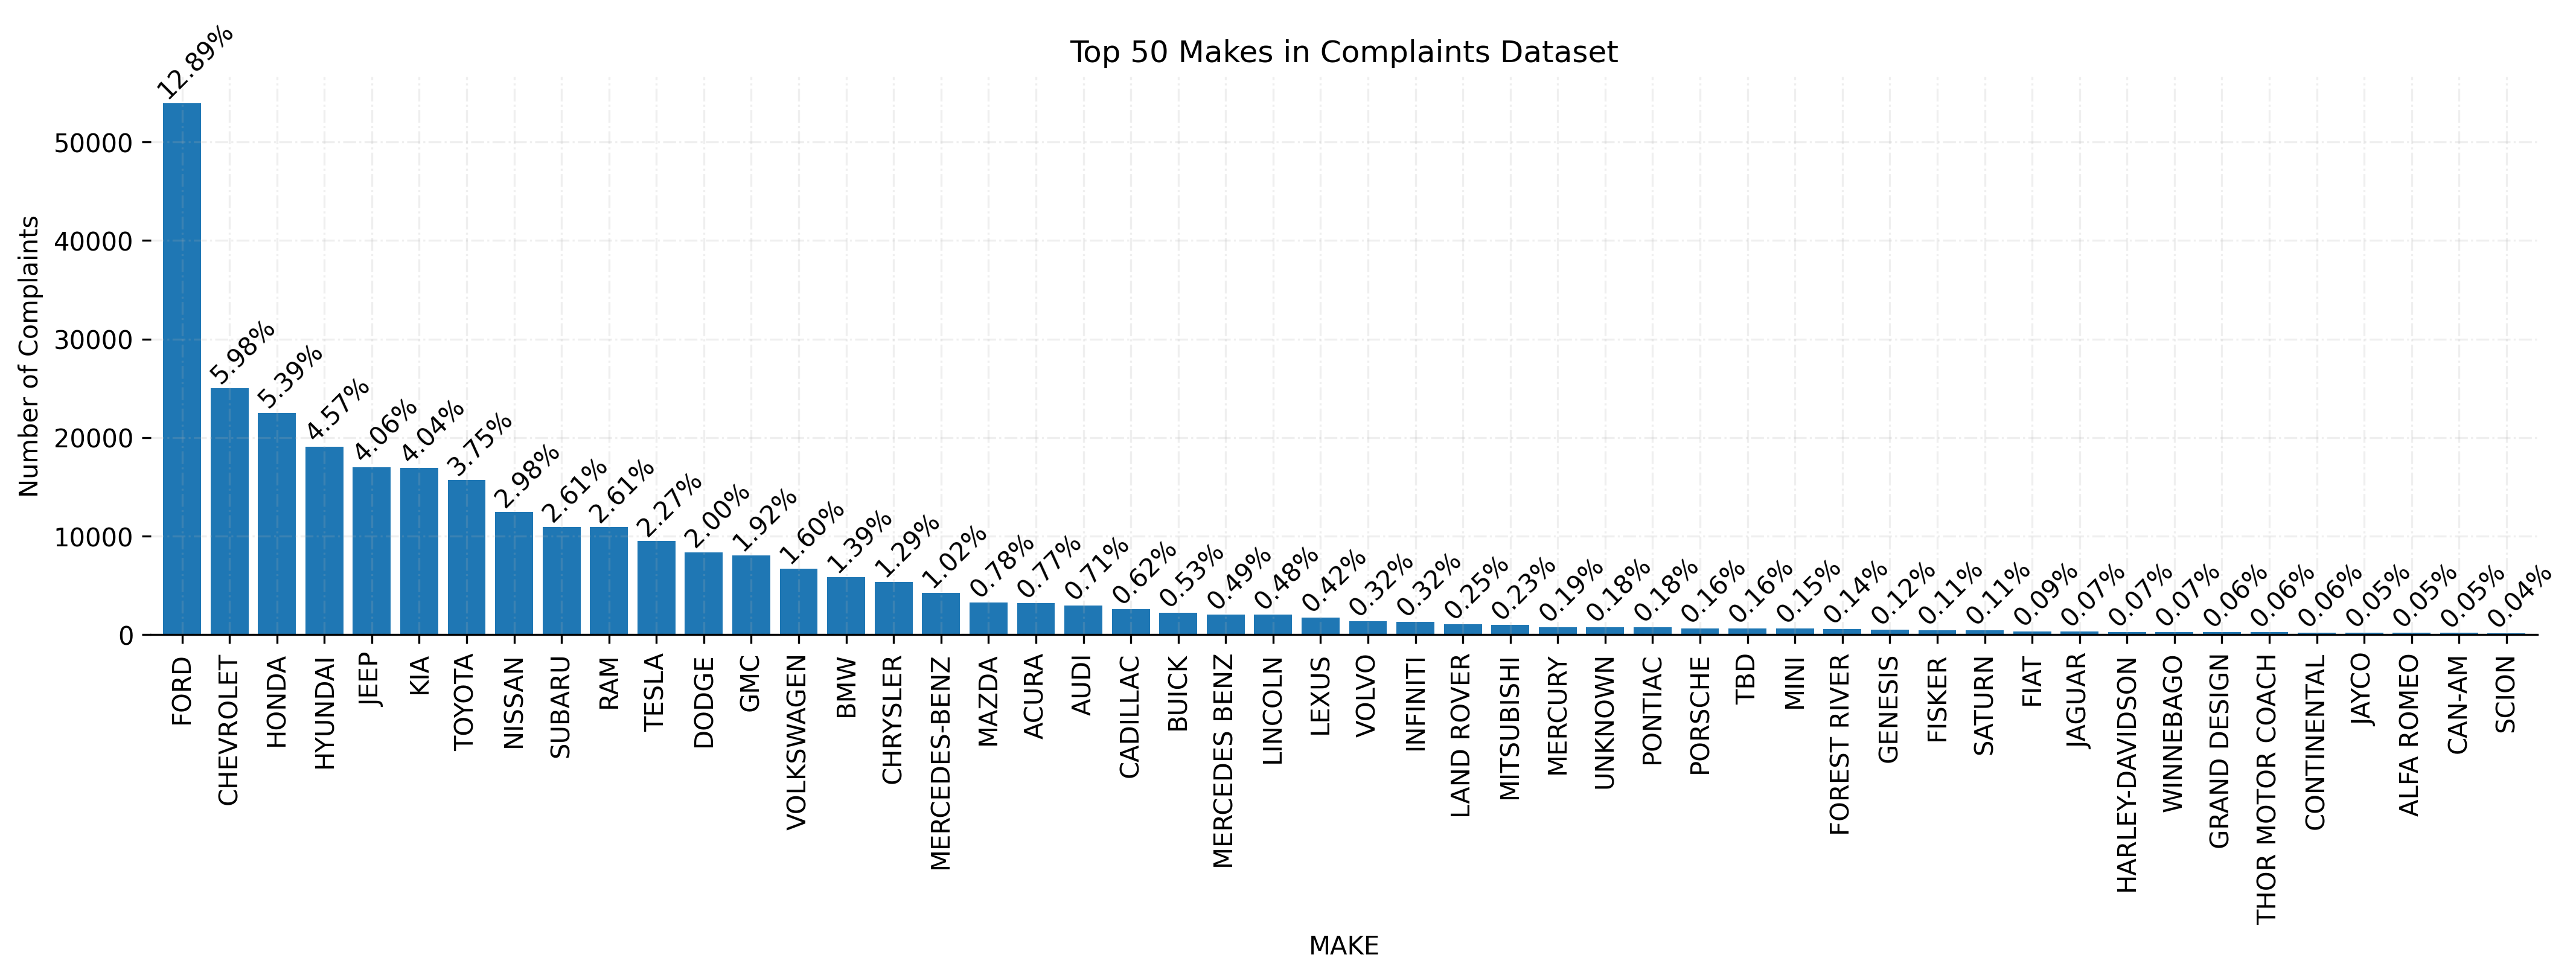

In [15]:
# Plot MAKETXT value counts with percentage text hovering over bar chart
plt.figure(figsize=(17, 4), dpi=300)
maketxt_value_counts = df_complaints.groupby("MAKETXT").nunique("CDESCR")["CDESCR"].sort_values(ascending=False)[:50]
maketxt_value_counts.plot(kind='bar', width=0.8)
for i, count in enumerate(maketxt_value_counts):
    plt.text(i + 0.3, count, f"{count / len(df_complaints) * 100:.2f}%", ha='center', va='bottom', rotation=45)
plt.title('Top 50 Makes in Complaints Dataset')
plt.xlabel('MAKE')
plt.ylabel('Number of Complaints')
plt.show()

### Year Distribution

In [16]:
df_complaints["YEARTXT"].describe()

count    418337.000000
mean       2124.024994
std         922.271198
min        1960.000000
25%        2013.000000
50%        2017.000000
75%        2019.000000
max        9999.000000
Name: YEARTXT, dtype: float64

In [17]:
df_complaints["YEARTXT"].quantile([0.75, 0.95, 0.99])

0.75    2019.0
0.95    2023.0
0.99    9999.0
Name: YEARTXT, dtype: float64

### CDESCR String Length

In [19]:
df_string_length = df_complaints["CDESCR"].drop_duplicates().str.len()

In [20]:
df_string_length.describe()

count    288836.000000
mean        564.820299
std         416.594688
min           0.000000
25%         263.000000
50%         485.000000
75%         738.000000
max       18994.000000
Name: CDESCR, dtype: float64

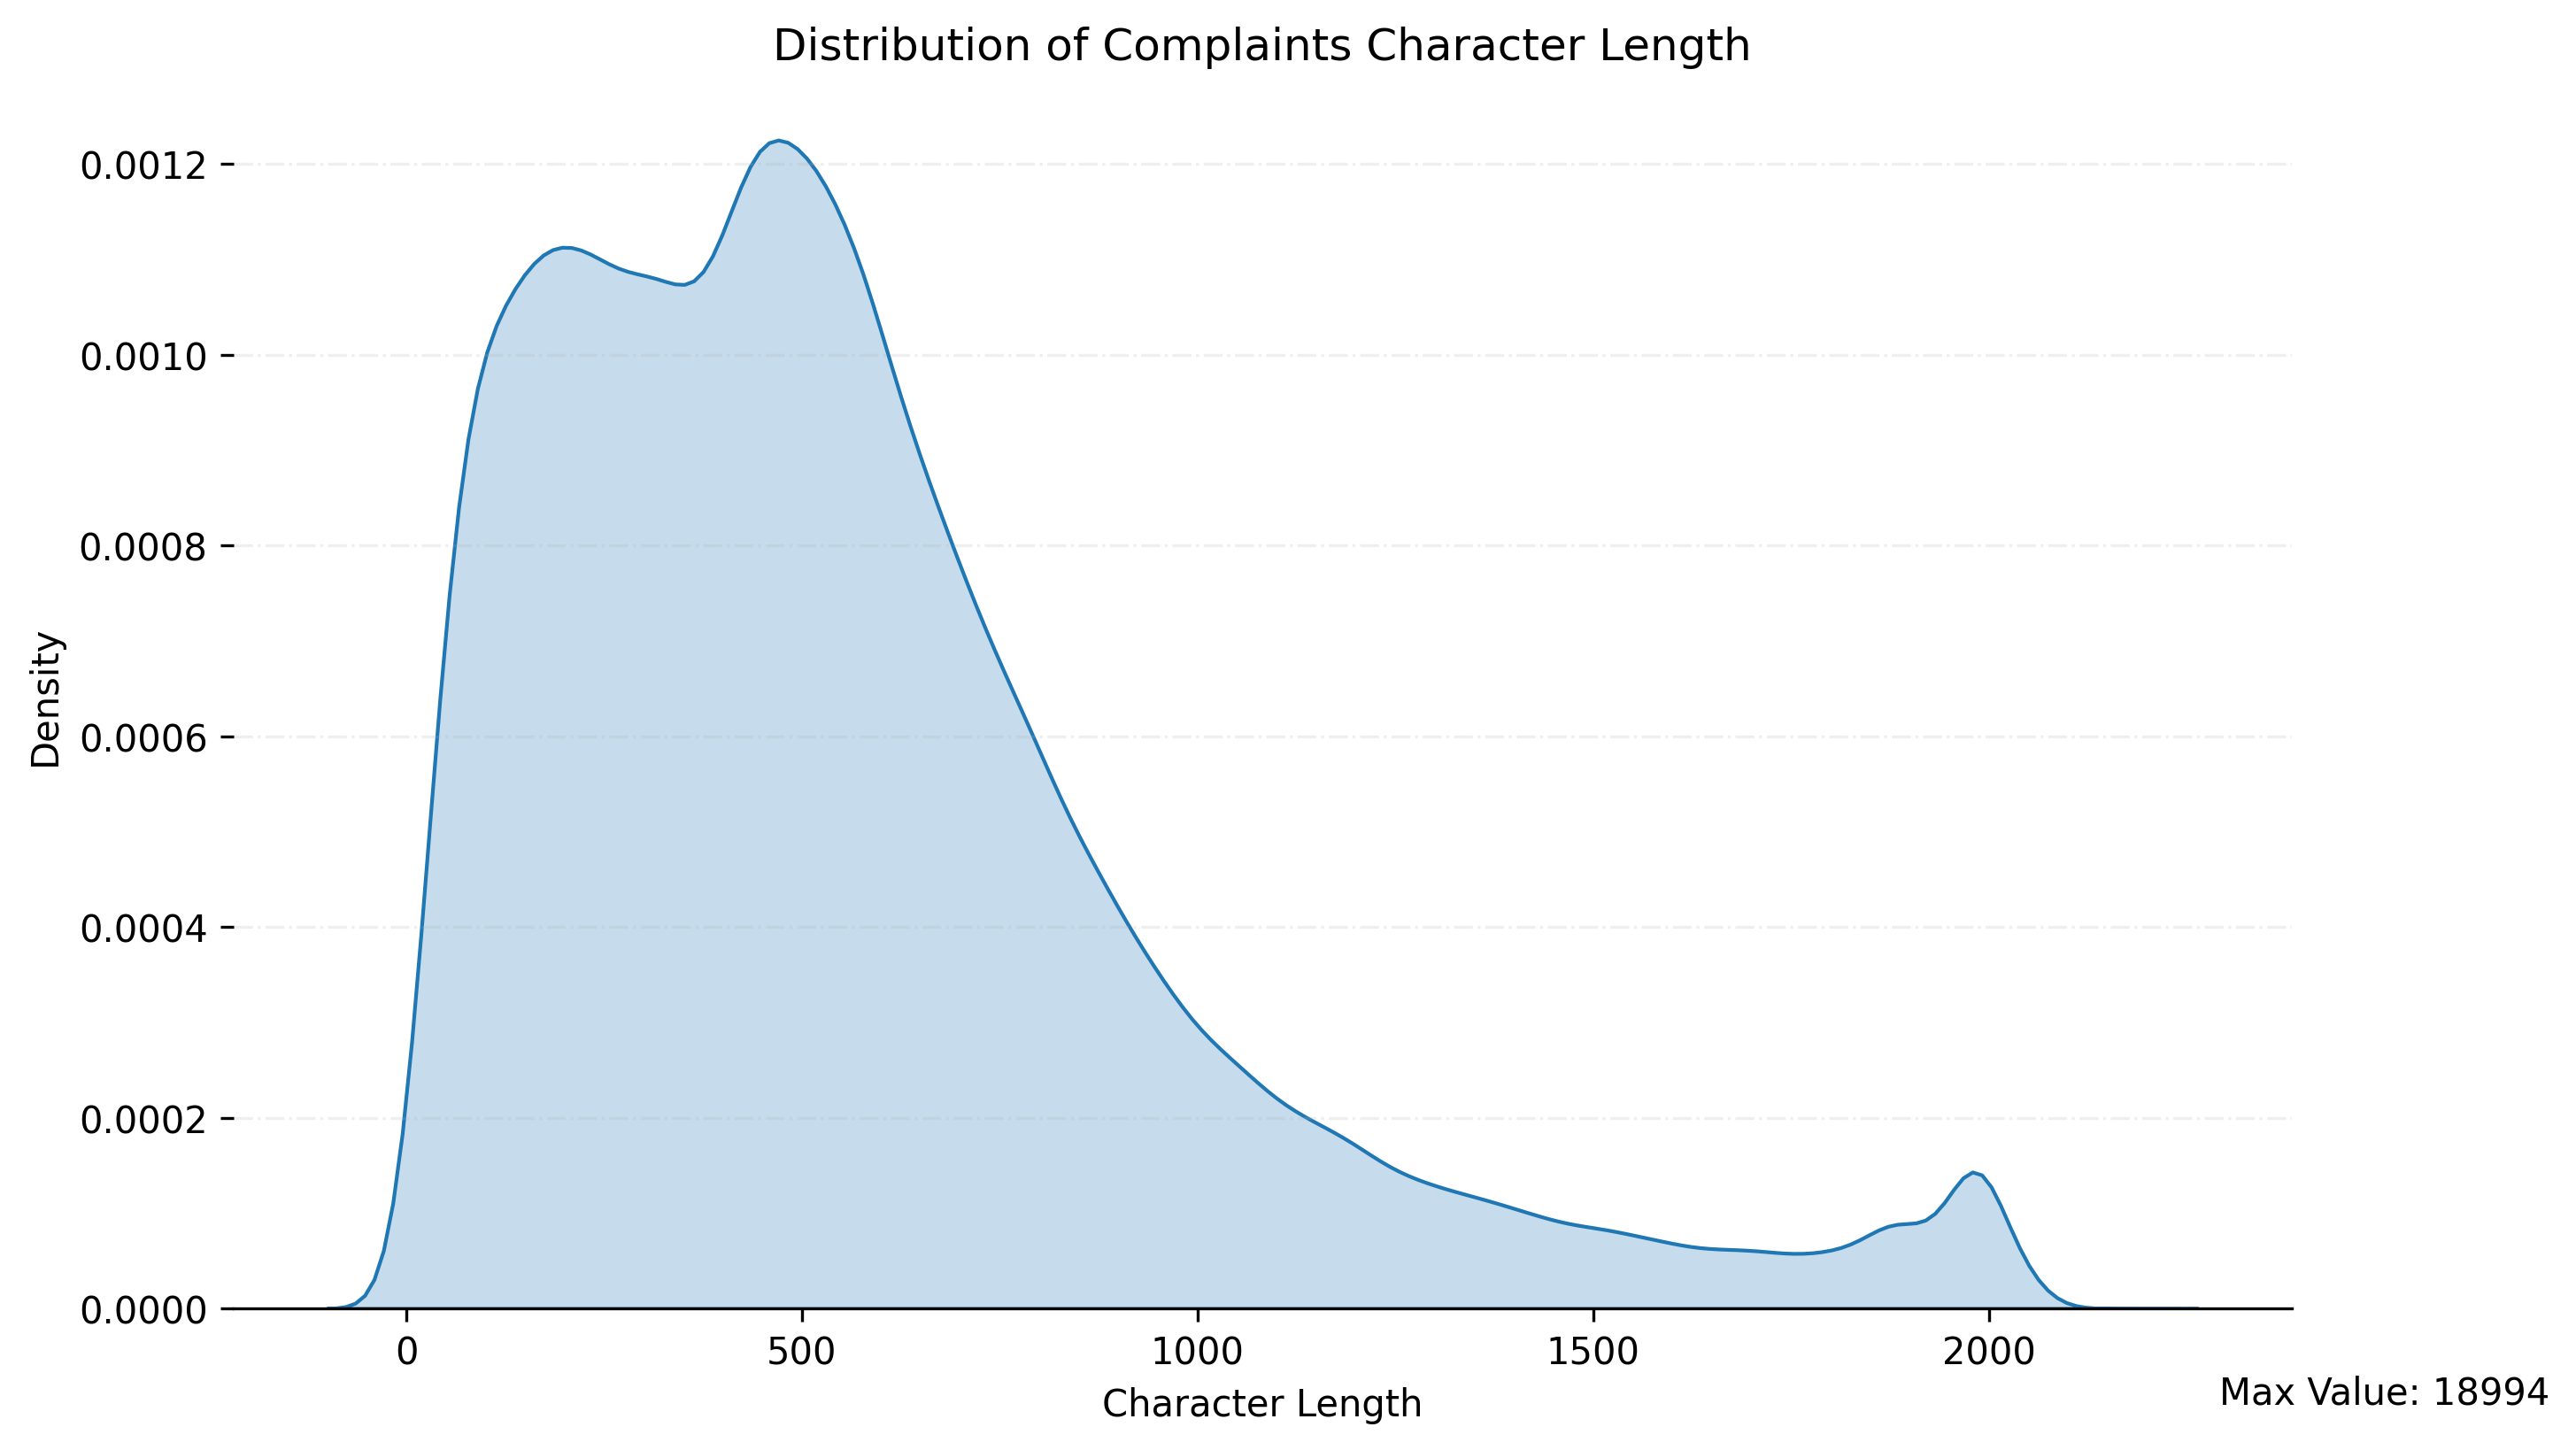

In [21]:
plt.figure(figsize=(10, 6), dpi=300)
sns.kdeplot(data=df_string_length[df_string_length < 3000], fill=True)
plt.title("Distribution of Complaints Character Length")
plt.xlabel("Character Length")
plt.ylabel("Density")
plt.text(2500, -0.0001, ha="center", s=f"Max Value: {df_string_length.max()}")
plt.show()


Why are complaints so long

### CMPL_TYPE 

In [22]:
df_complaints["CMPL_TYPE"].unique()

array(['IVOQ', 'LETR', 'EVOQ', 'SVOQ', 'CON', 'MIVQ', 'VOQ', 'DP'],
      dtype=object)

In [23]:
complaint_type_definitions = {
    "CAG": "Consumer Action Group",
    "CON": "Congressional Office",
    "DP": "Defect Petition",
    "EVOQ": "Hotline VOQ",
    "EWR": "Early Warning Report",
    "INS": "Insurance Company",
    "IVOQ": "NHTSA Web Site",
    "LETR": "Consumer Letter",
    "MAVQ": "NHTSA Mobile App",
    "MIVQ": "NHTSA Mobile App",
    "MVOQ": "Optical Marked VOQ",
    "RC": "Recall Complaint",
    "RP": "Recall Petition",
    "SVOQ": "Portable Safety Complaint Form (PDF)",
    "VOQ": "NHTSA Vehicle Owners Questionnaire"
}

# Replace complaint types with human-readable texts
df_complaints["CMPL_TYPE"] = df_complaints["CMPL_TYPE"].map(complaint_type_definitions)

In [26]:
complaints_value_counts = df_complaints.drop_duplicates(subset=["CDESCR"])["CMPL_TYPE"].value_counts()

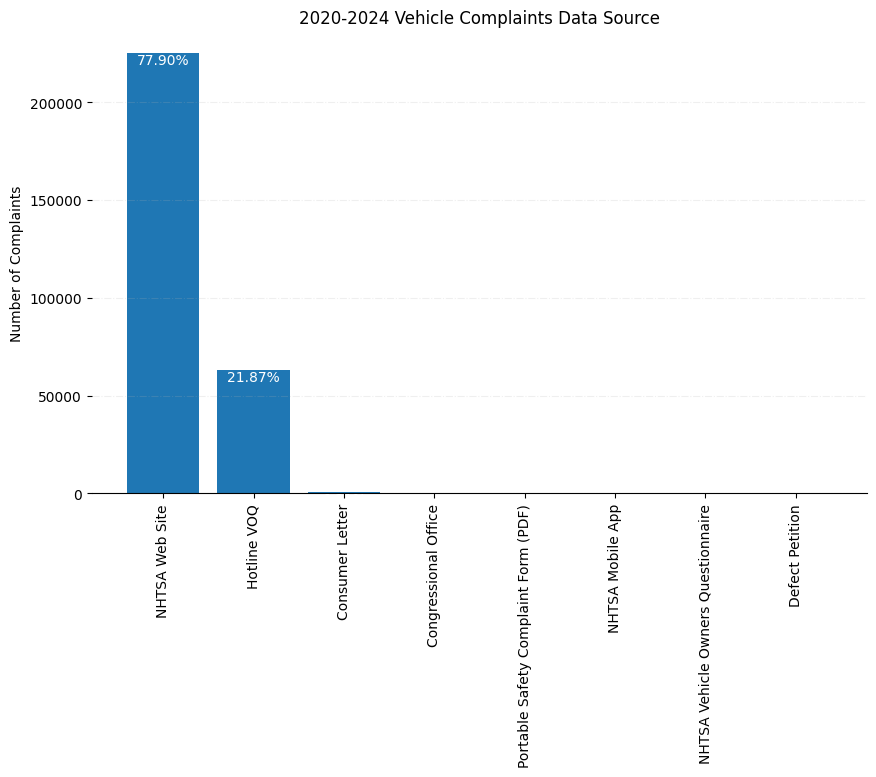

In [28]:
plt.figure(figsize=(10, 6))
_ = plt.bar(
    x=complaints_value_counts.index,
    height=complaints_value_counts.values
)
for i, count in enumerate(complaints_value_counts):
    plt.text(i, count, f"{count / sum(complaints_value_counts) * 100:.2f}%", ha='center', va='top', color="white")
_ = plt.xticks(rotation=90)
_ = plt.title("2020-2024 Vehicle Complaints Data Source")
_ = plt.ylabel("Number of Complaints")

### COMPDESC Distribution

Component Description

In [29]:
compname_word_freq = generate_word_frequencies_from_column(df_complaints, "COMPDESC")

In [30]:
wordcloud = WordCloud(width = 1600, height = 800,
                background_color ='white',
                collocations=False,
                relative_scaling=0.75, # Ranges from 0-1. 
                                       # =0.75 weights word size by frequency moreso than word rank
                min_font_size = 10).generate_from_frequencies(compname_word_freq.to_dict()["count"])

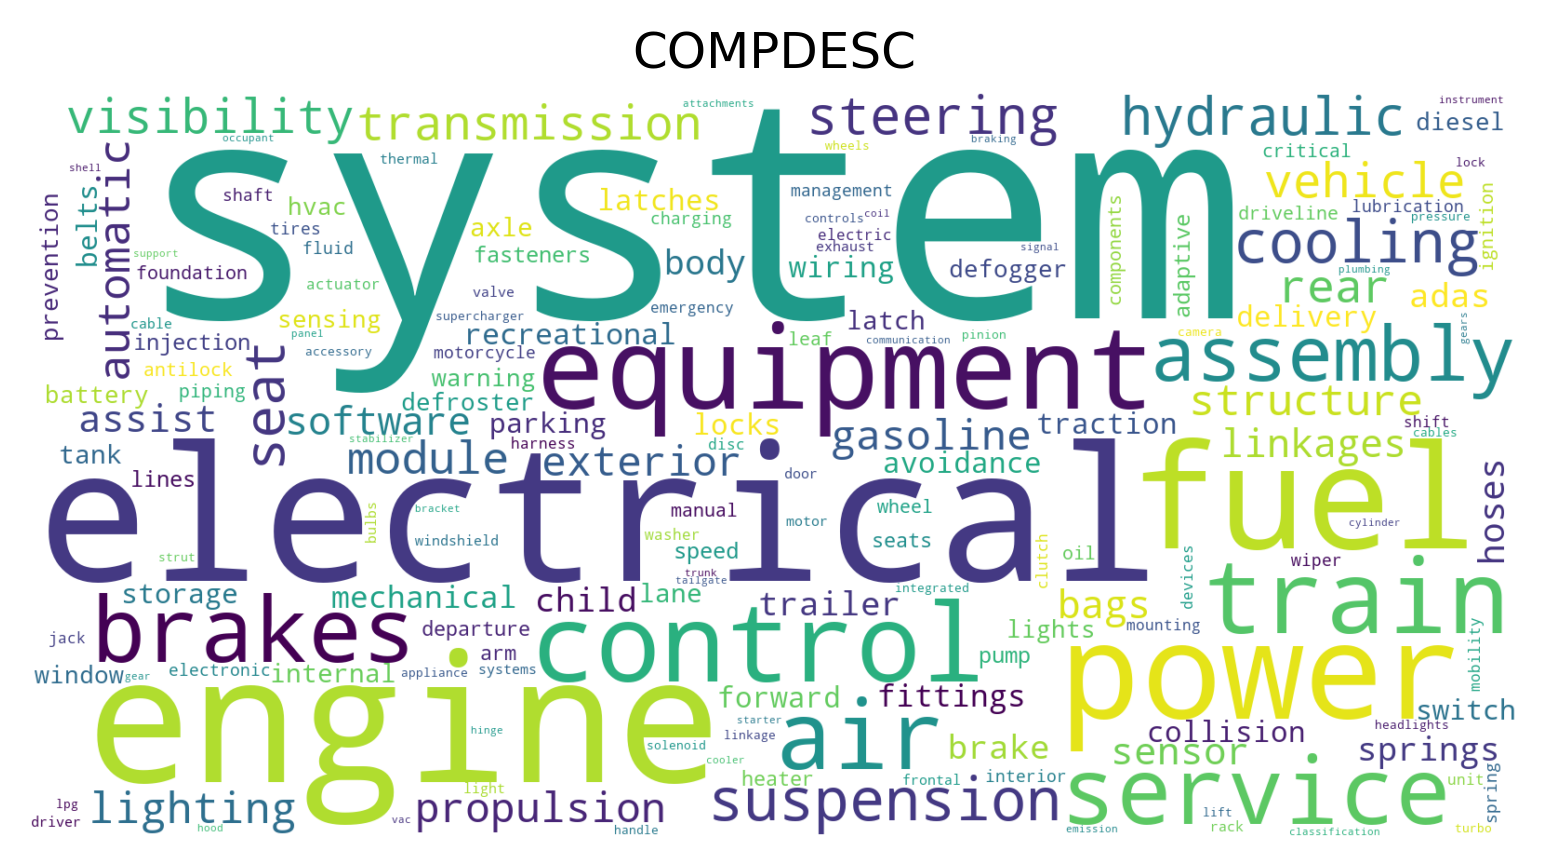

In [31]:
plt.figure(dpi=300)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
_ = plt.title('COMPDESC')

In [34]:
wordcloud = WordCloud(width = 1600, height = 800,
                background_color ='white',
                regexp="\\b\\w\\w+\\b",
                include_numbers=False,
                collocations=True,
                stopwords=nlp.Defaults.stop_words,
                collocation_threshold=-999,
                relative_scaling=1, # Ranges from 0-1. 
                                       # =0.75 weights word size by frequency moreso than word rank
                min_font_size = 10).generate(df_complaints["COMPDESC"].drop_duplicates().str.cat(sep=" "))

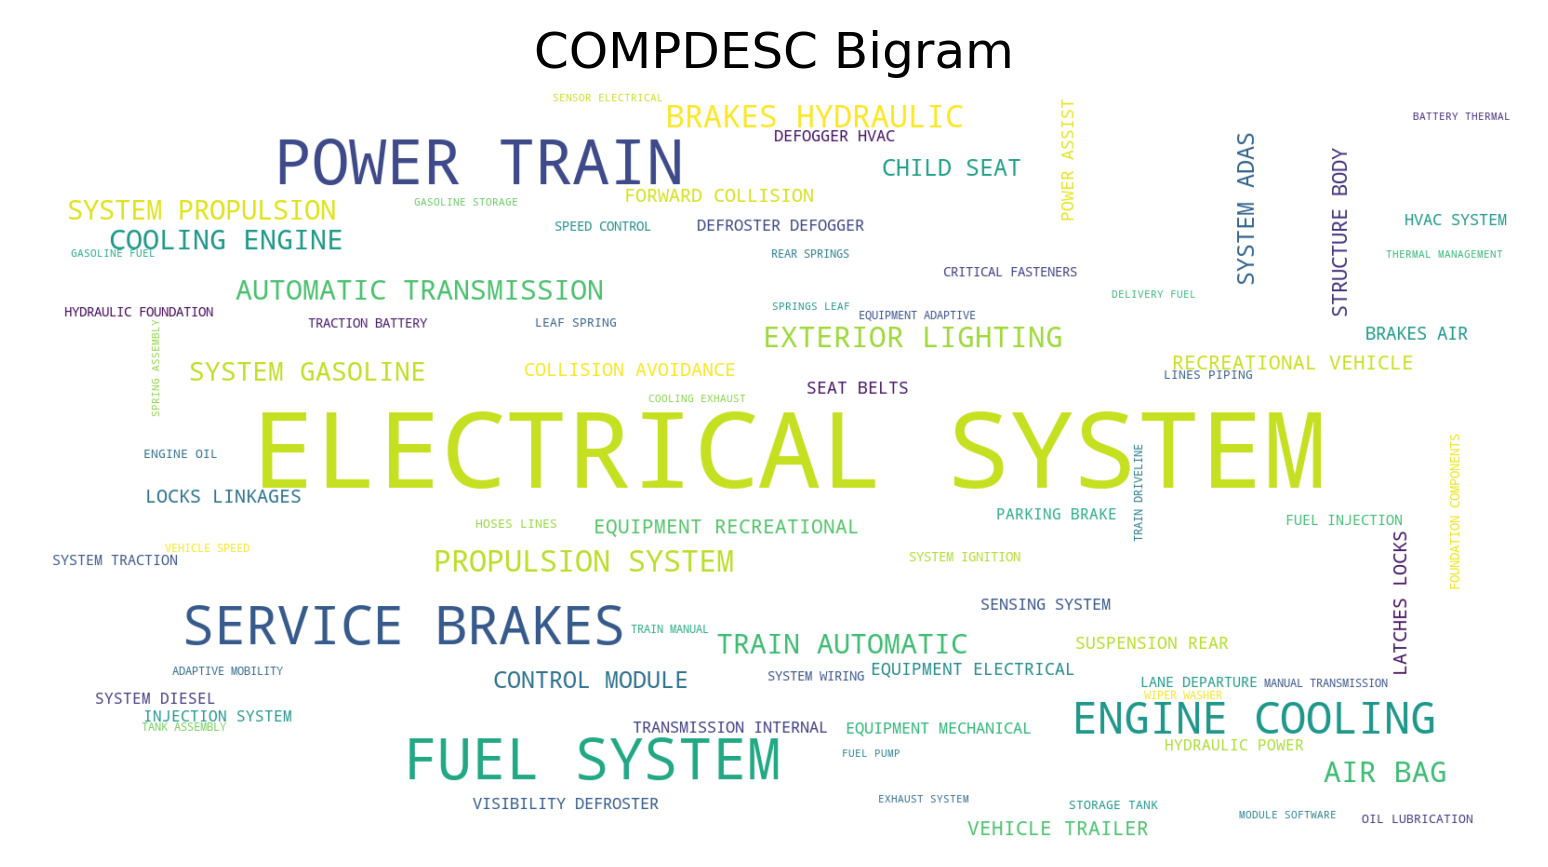

In [35]:
plt.figure(dpi=300)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
_ = plt.title('COMPDESC Bigram')

In [37]:
df_string_length = df_complaints["COMPDESC"].drop_duplicates().str.len()

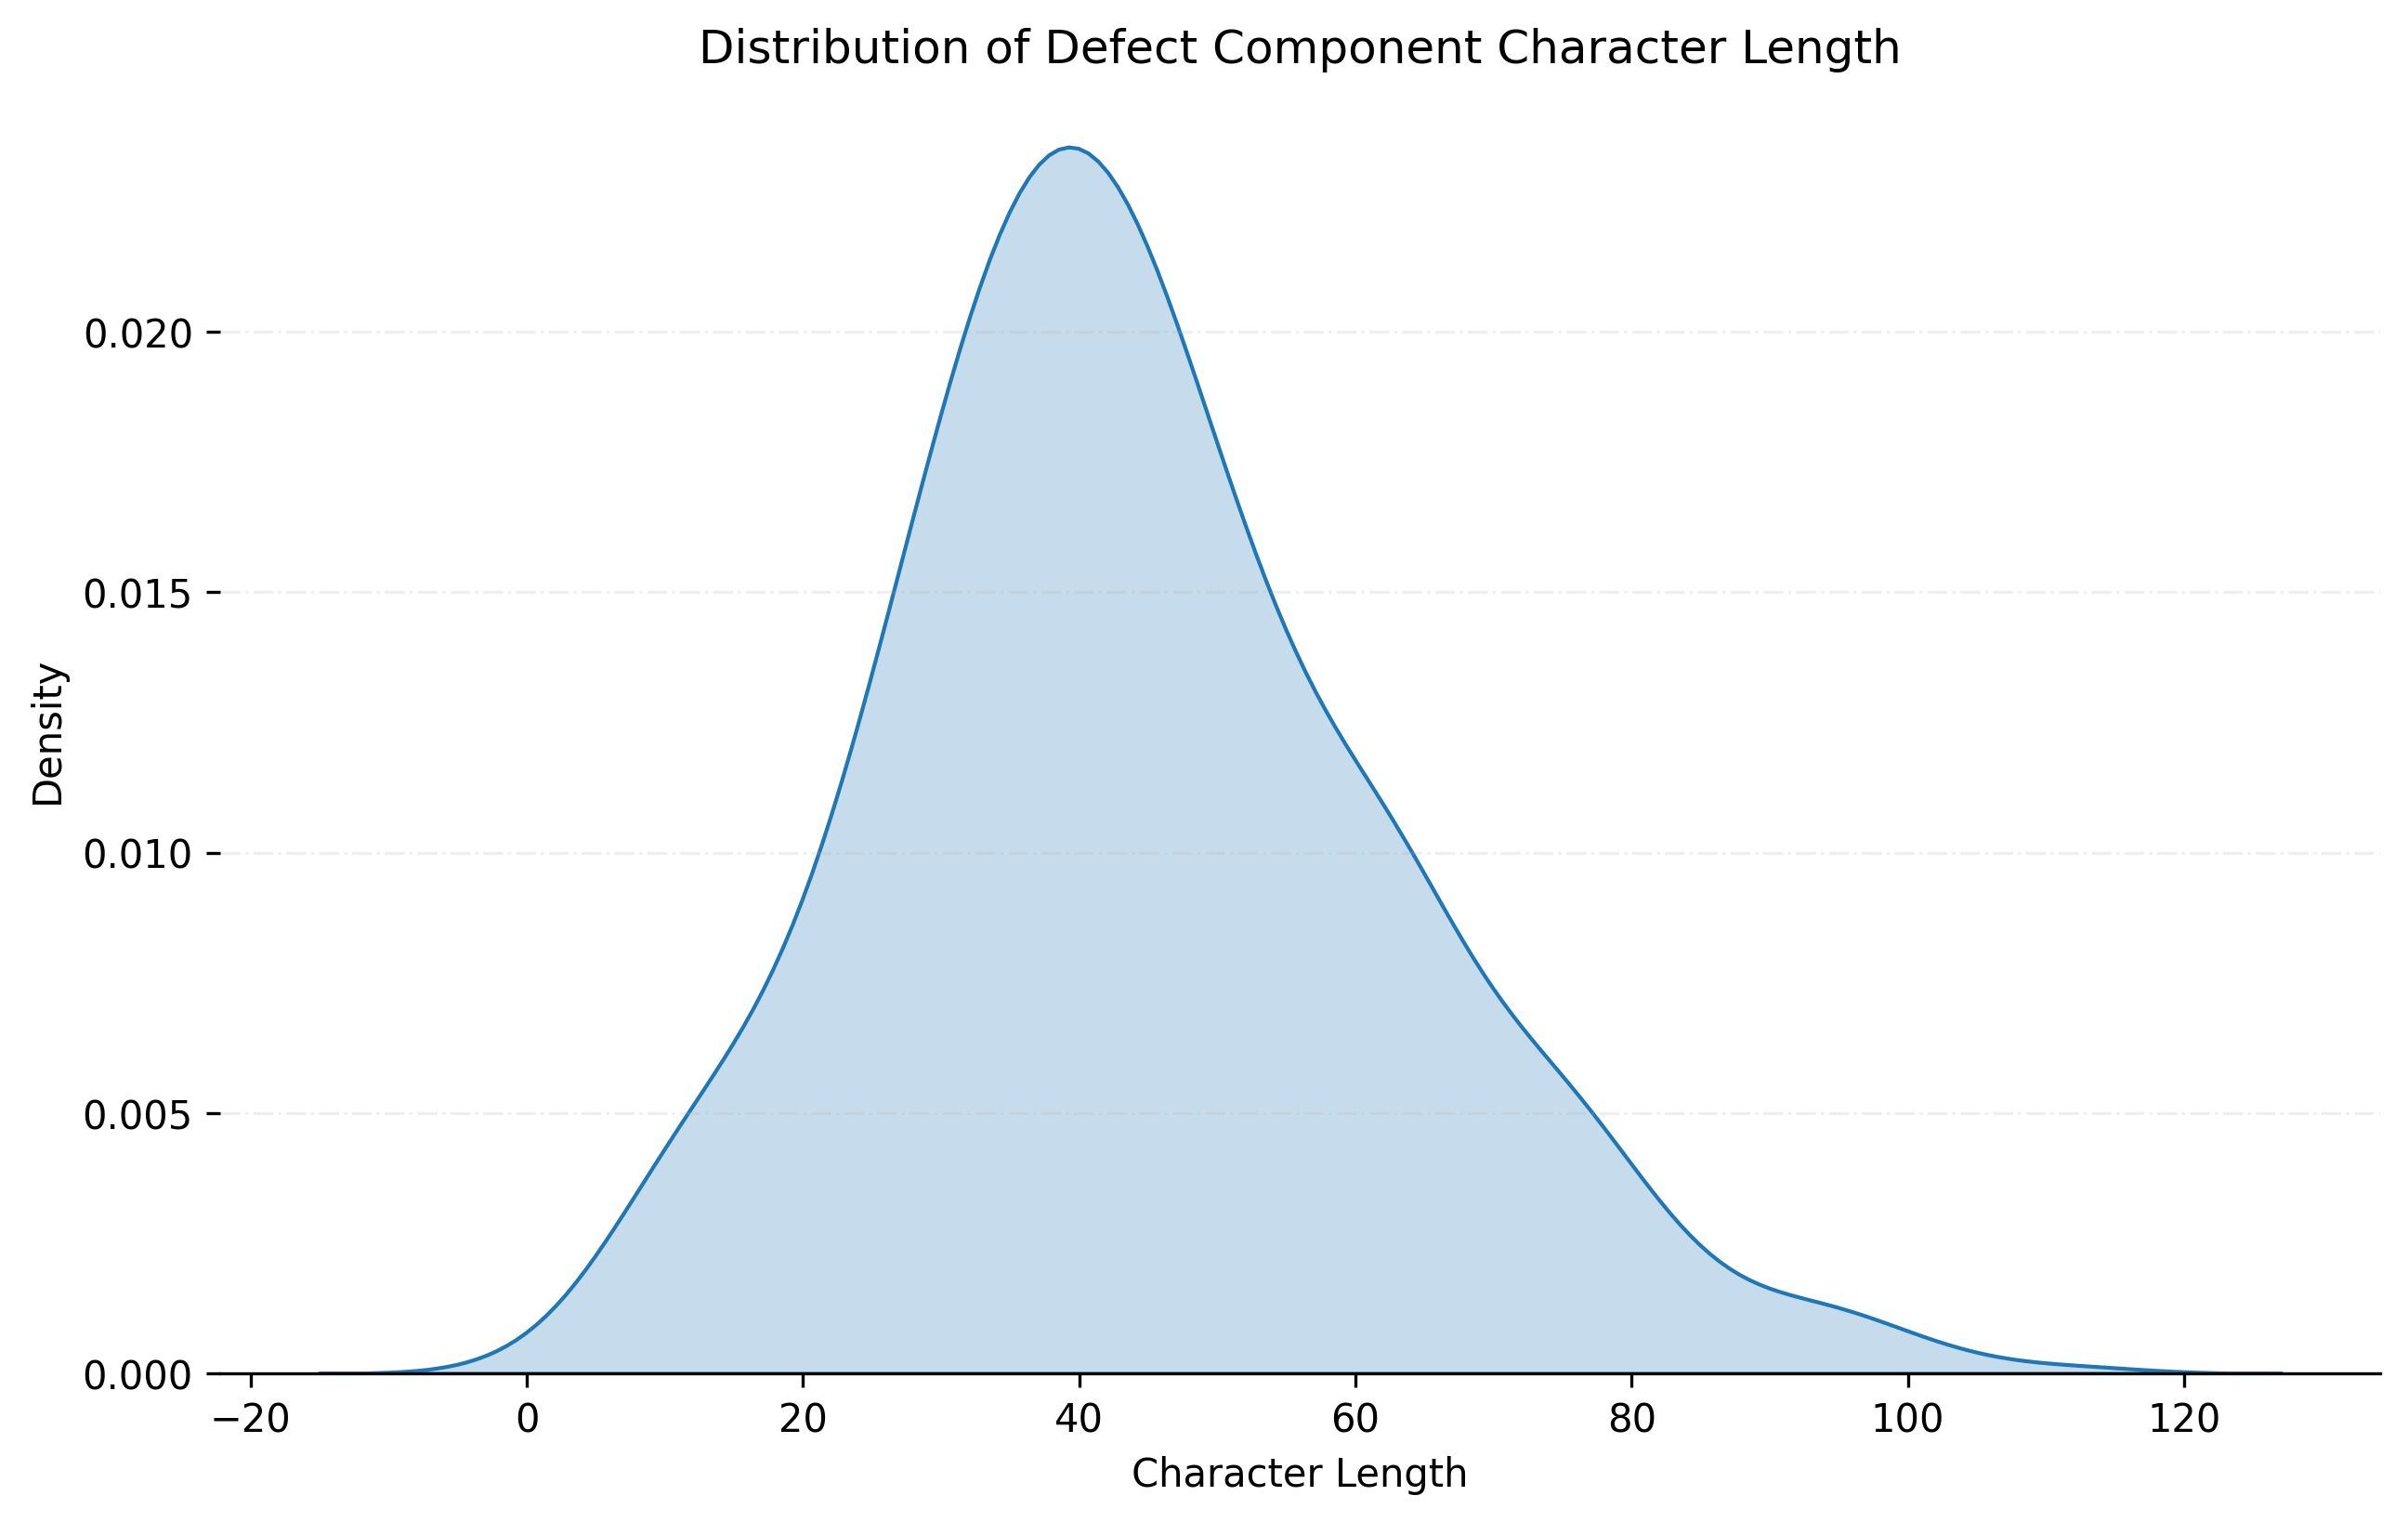

In [38]:
plt.figure(figsize=(10, 6), dpi=300)
sns.kdeplot(data=df_string_length, fill=True)
plt.title("Distribution of Defect Component Character Length")
plt.xlabel("Character Length")
plt.ylabel("Density")
# plt.text(2500, -0.0001, ha="center", s=f"Max Value: {df_string_length.max()}")
plt.show()


### Complaints Wordmap

In [40]:
complaints_word_freq = generate_word_frequencies_from_column(df_complaints, "CDESCR")


In [ ]:
# complaints_word_freq = complaints_word_freq.iloc[100:]

In [41]:
wordcloud = WordCloud(width = 1600, height = 800,
                background_color ='white',
                collocations=False,
                relative_scaling=0.75, # Ranges from 0-1. 
                                       # =0.75 weights word size by frequency moreso than word rank
                min_font_size = 10).generate_from_frequencies(complaints_word_freq.to_dict()["count"])

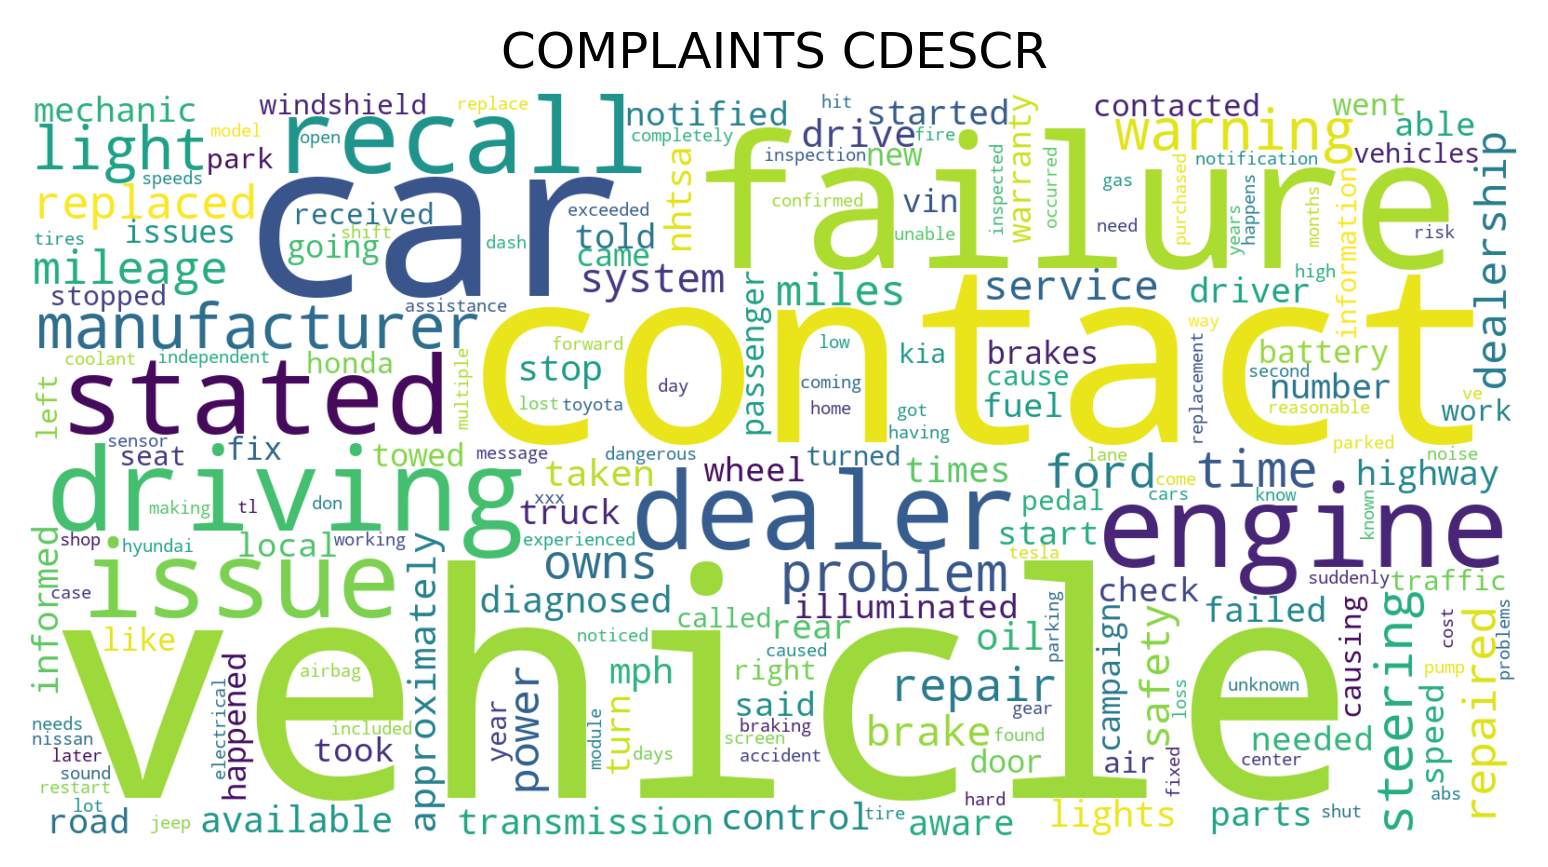

In [42]:
plt.figure(dpi=300)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
_ = plt.title('COMPLAINTS CDESCR')

In [43]:
wordcloud = WordCloud(width = 1600, height = 800,
                background_color ='white',
                regexp="\\b\\w\\w+\\b",
                include_numbers=False,
                collocations=True,
                stopwords=nlp.Defaults.stop_words,
                collocation_threshold=-999,
                relative_scaling=1, # Ranges from 0-1. 
                                       # =0.75 weights word size by frequency moreso than word rank
                min_font_size = 10).generate(df_complaints["CDESCR"].drop_duplicates().str.cat(sep=" "))

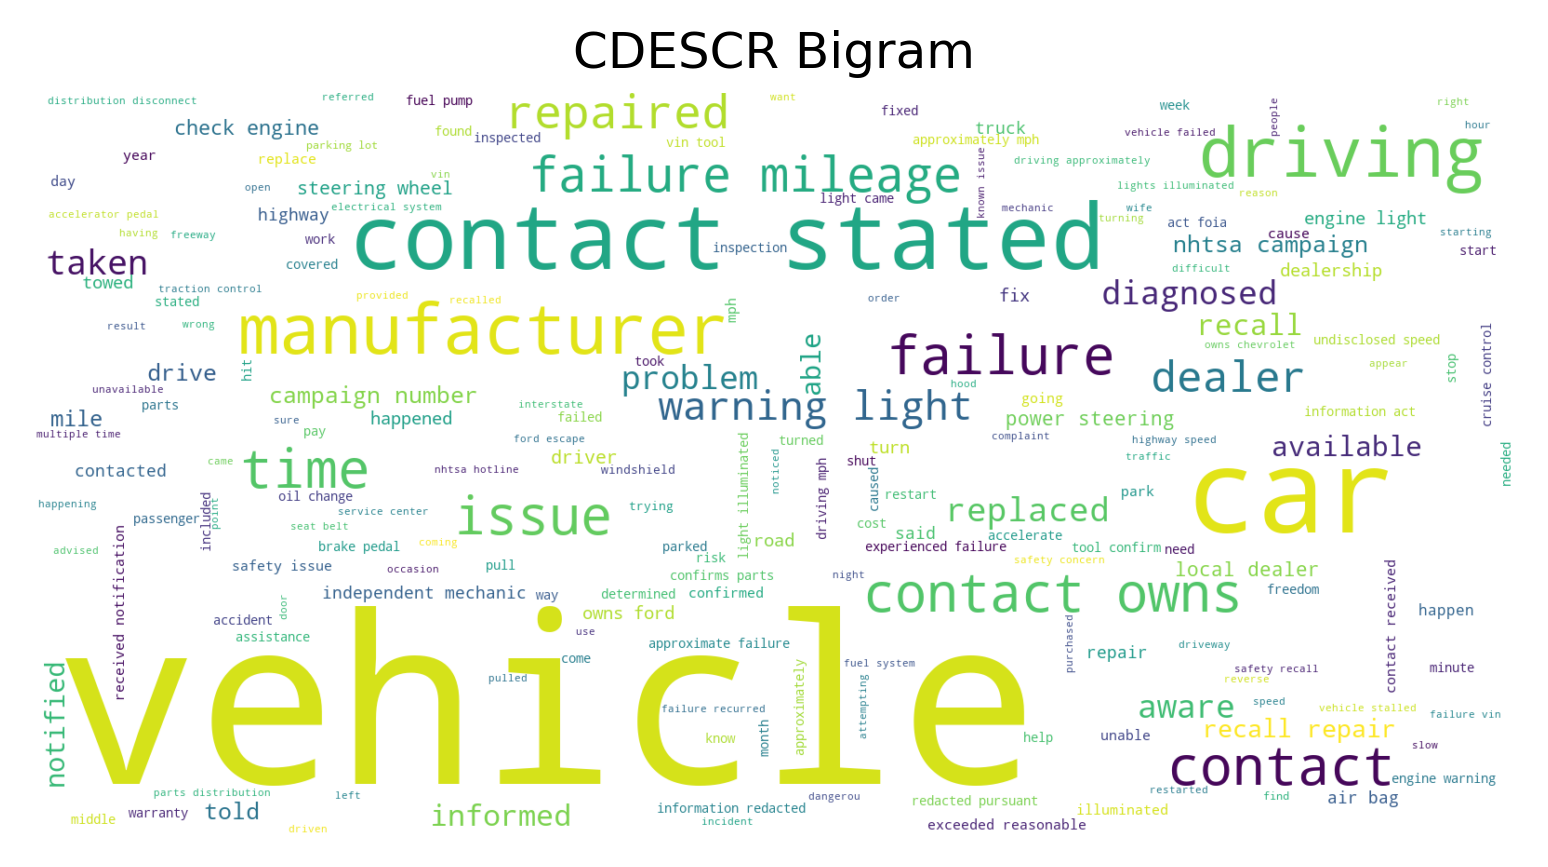

In [44]:
plt.figure(dpi=300)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
_ = plt.title('CDESCR Bigram')

In [45]:
get_random_row(df_complaints)   

ODINO: 11405357
'FAILDATE: 20210312'
'CITY: FREEPORT'
'STATE: TX'
'COMPDESC: ELECTRICAL SYSTEM'
('CDESCR: tipm has everything going crazy. when the jeep is started the wriper '
 'start wiping and the the lights quit and there are no blinkers. also happen '
 'when in movement.')


## Data Quality Check

In [37]:
len(df_complaints["ODINO"])

418344

In [38]:
len(df_complaints["ODINO"].unique())

291756

### Duplicate Check Using Samples

In [ ]:
df_complaints_duplicates = df_complaints.loc[
    df_complaints.groupby("ODINO").transform("size") >= 2
]

In [259]:
df_complaints_duplicates

,ODINO,MFR_NAME,MAKETXT,MODELTXT,YEARTXT,CRASH,FAILDATE,FIRE,INJURED,DEATHS,...,DEALER_NAME,DEALER_TEL,DEALER_CITY,DEALER_STATE,DEALER_ZIP,PROD_TYPE,REPAIRED_YN,MEDICAL_ATTN,VEHICLES_TOWED_YN,MMYTXT
0,,,,,,,,,,,,,,,,,,,,,
1633298,11292384,honda (american honda motor co.),honda,accord,2018.0,n,20191221,n,0,0,...,,,,,,v,,n,n,honda accord 2018.0
1633299,11292384,honda (american honda motor co.),honda,accord,2018.0,n,20191221,n,0,0,...,,,,,,v,,n,n,honda accord 2018.0
1633300,11292384,honda (american honda motor co.),honda,accord,2018.0,n,20191221,n,0,0,...,,,,,,v,,n,n,honda accord 2018.0
1633302,11292386,"general motors, llc",chevrolet,volt,2017.0,n,20190712,n,0,0,...,,,,,,v,,n,n,chevrolet volt 2017.0
1633303,11292386,"general motors, llc",chevrolet,volt,2017.0,n,20190712,n,0,0,...,,,,,,v,,n,n,chevrolet volt 2017.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2051715,11633470,"kia america, inc.",kia,soul,2019.0,n,20221125,n,0,0,...,,,,,,v,,n,n,kia soul 2019.0
2051716,11633470,"kia america, inc.",kia,soul,2019.0,n,20221125,n,0,0,...,,,,,,v,,n,n,kia soul 2019.0
2051717,11633471,"tesla, inc.",tesla,model x,2018.0,n,20241220,n,0,0,...,,,,,,v,,n,n,tesla model x 2018.0


In [92]:
get_random_row(
    df_complaints_duplicates.loc[
        df_complaints["ODINO"] == 11292386
    ].iloc[[0]]
)

ODINO: 11292386
'FAILDATE: 20190712'
'CITY: SAN ANTONIO'
'STATE: TX'
'COMPDESC: SERVICE BRAKES'
('CDESCR: while driving on city streets and highways, the adaptive cruise '
 'control will not engage 25% of the time and will disengage without notice.  '
 '"adaptive cruise control will appear in dic.  however, this creates a safety '
 'hazard as you never know if the car will automatically slow down.  i have '
 'filed case # 9-5379585813 with chevrolet and been to four dealers and they '
 'refuse to fix the problem.  they no longer return my calls.  i am afraid to '
 'use the cruise control.')


In [93]:
get_random_row(
    df_complaints_duplicates.loc[
        df_complaints["ODINO"] == 11292386
    ].iloc[[1]]
)

ODINO: 11292386
'FAILDATE: 20190712'
'CITY: SAN ANTONIO'
'STATE: TX'
'COMPDESC: ELECTRONIC STABILITY CONTROL (ESC)'
('CDESCR: while driving on city streets and highways, the adaptive cruise '
 'control will not engage 25% of the time and will disengage without notice.  '
 '"adaptive cruise control will appear in dic.  however, this creates a safety '
 'hazard as you never know if the car will automatically slow down.  i have '
 'filed case # 9-5379585813 with chevrolet and been to four dealers and they '
 'refuse to fix the problem.  they no longer return my calls.  i am afraid to '
 'use the cruise control.')


In [94]:
get_random_row(
    df_complaints_duplicates.loc[
        df_complaints["ODINO"] == 11292386
    ].iloc[[2]]
)

ODINO: 11292386
'FAILDATE: 20190712'
'CITY: SAN ANTONIO'
'STATE: TX'
'COMPDESC: VEHICLE SPEED CONTROL'
('CDESCR: while driving on city streets and highways, the adaptive cruise '
 'control will not engage 25% of the time and will disengage without notice.  '
 '"adaptive cruise control will appear in dic.  however, this creates a safety '
 'hazard as you never know if the car will automatically slow down.  i have '
 'filed case # 9-5379585813 with chevrolet and been to four dealers and they '
 'refuse to fix the problem.  they no longer return my calls.  i am afraid to '
 'use the cruise control.')


In [97]:
df_complaints_duplicates.sample(random_state=42)

,ODINO,MFR_NAME,MAKETXT,MODELTXT,YEARTXT,CRASH,FAILDATE,FIRE,INJURED,DEATHS,...,RESTRAINT_TYPE,DEALER_NAME,DEALER_TEL,DEALER_CITY,DEALER_STATE,DEALER_ZIP,PROD_TYPE,REPAIRED_YN,MEDICAL_ATTN,VEHICLES_TOWED_YN
0,,,,,,,,,,,,,,,,,,,,,
1636435,11298812,"General Motors, LLC",CHEVROLET,CRUZE,2015.0,N,20200110,N,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,V,NaN,N,N


In [100]:
df_complaints_duplicates.loc[
    df_complaints["ODINO"] == 11298812
]

,ODINO,MFR_NAME,MAKETXT,MODELTXT,YEARTXT,CRASH,FAILDATE,FIRE,INJURED,DEATHS,...,RESTRAINT_TYPE,DEALER_NAME,DEALER_TEL,DEALER_CITY,DEALER_STATE,DEALER_ZIP,PROD_TYPE,REPAIRED_YN,MEDICAL_ATTN,VEHICLES_TOWED_YN
0,,,,,,,,,,,,,,,,,,,,,
1636435,11298812,"General Motors, LLC",CHEVROLET,CRUZE,2015.0,N,20200110,N,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,V,NaN,N,N
1636436,11298812,"General Motors, LLC",CHEVROLET,CRUZE,2015.0,N,20200110,N,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,V,NaN,N,N


In [101]:
get_random_row(df_complaints_duplicates.loc[
    df_complaints["ODINO"] == 11298812
].iloc[[0]])

ODINO: 11298812
'FAILDATE: 20200110'
'CITY: PALMDALE'
'STATE: CA'
'COMPDESC: ENGINE'
('CDESCR: the car overheats whenever the air is turned on. replaced thermostat '
 'and had the radiator replaced. no resolution.')


In [102]:
get_random_row(df_complaints_duplicates.loc[
    df_complaints["ODINO"] == 11298812
].iloc[[1]])

ODINO: 11298812
'FAILDATE: 20200110'
'CITY: PALMDALE'
'STATE: CA'
'COMPDESC: UNKNOWN OR OTHER'
('CDESCR: the car overheats whenever the air is turned on. replaced thermostat '
 'and had the radiator replaced. no resolution.')


In [99]:
df_complaints_duplicates.sample(random_state=41)

,ODINO,MFR_NAME,MAKETXT,MODELTXT,YEARTXT,CRASH,FAILDATE,FIRE,INJURED,DEATHS,...,RESTRAINT_TYPE,DEALER_NAME,DEALER_TEL,DEALER_CITY,DEALER_STATE,DEALER_ZIP,PROD_TYPE,REPAIRED_YN,MEDICAL_ATTN,VEHICLES_TOWED_YN
0,,,,,,,,,,,,,,,,,,,,,
1634064,11296943,Hyundai Motor America,HYUNDAI,SANTA FE,2011.0,N,20190801,N,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,V,NaN,N,N


In [103]:
get_random_row(df_complaints_duplicates.loc[
    df_complaints["ODINO"] == 11296943
].iloc[[0]])

ODINO: 11296943
'FAILDATE: 20190801'
'CITY: CAMPBELL HALL'
'STATE: NY'
'COMPDESC: SERVICE BRAKES, HYDRAULIC'
('CDESCR: tl* the contact owns a 2011 hyundai santa fe. while driving various '
 'speeds, the rear calipers seized. also, when the brake pedal was applied, '
 'the pedal felt spongy and traveled to the floorboard. there were no warning '
 'indicators illuminated. the vehicle was taken to an independent mechanic who '
 'stated that the calipers seized and the master cylinder and brake pads '
 'needed to be replaced. the local dealer and manufacturer were not contacted. '
 'the contact stated that the failure was similar to nhtsa campaign number: '
 '10v613000 (service brakes, hydraulic). the failure mileage was '
 '115,000.*dt*jb')


In [104]:
get_random_row(df_complaints_duplicates.loc[
    df_complaints["ODINO"] == 11296943
].iloc[[1]])

ODINO: 11296943
'FAILDATE: 20190801'
'CITY: CAMPBELL HALL'
'STATE: NY'
'COMPDESC: SERVICE BRAKES'
('CDESCR: tl* the contact owns a 2011 hyundai santa fe. while driving various '
 'speeds, the rear calipers seized. also, when the brake pedal was applied, '
 'the pedal felt spongy and traveled to the floorboard. there were no warning '
 'indicators illuminated. the vehicle was taken to an independent mechanic who '
 'stated that the calipers seized and the master cylinder and brake pads '
 'needed to be replaced. the local dealer and manufacturer were not contacted. '
 'the contact stated that the failure was similar to nhtsa campaign number: '
 '10v613000 (service brakes, hydraulic). the failure mileage was '
 '115,000.*dt*jb')


What I'm seeing is duplication due to COMPDESC, where one ODINO record has multiple entries for the same CDESCR due to multiple vehicle components having issues.

### Logical Duplicate Check

In [260]:
len(df_complaints) - len(df_complaints.drop_duplicates())

26

26 duplicates when subset is all columns. However, I'm more interested in what is considered "unique" per ODINO

In [261]:
len(df_complaints)

418344

In [263]:
df_complaints.groupby("ODINO").nunique().sum(axis=0).sort_values(ascending=False)


COMPDESC             415060
MMYTXT               294790
PROD_TYPE            294788
MODELTXT             294787
CRUISE_CONT_YN       294780
ANTI_BRAKES_YN       294780
VEHICLES_TOWED_YN    294780
ORIG_OWNER_YN        294780
YEARTXT              294742
MAKETXT              294740
MFR_NAME             294732
VIN                  294508
REPAIRED_YN          293608
LOC_OF_TIRE          293288
DOT                  293066
ORIG_EQUIP_YN        292752
TIRE_FAIL_TYPE       292274
TIRE_SIZE            291997
FUEL_TYPE            291948
DRIVE_TRAIN          291944
DEALER_NAME          291918
RESTRAINT_TYPE       291911
SEAT_TYPE            291909
DEALER_CITY          291901
DEALER_STATE         291900
DEALER_ZIP           291873
DEALER_TEL           291801
TRANS_TYPE           291775
CDESCR               291757
CRASH                291756
FAILDATE             291756
INJURED              291756
CMPL_TYPE            291756
LDATE                291756
DATEA                291756
STATE               

Grouping by ODINO, we can see that 415058 row entries of COMP DESC is exclusive for a specific ODINO.

In [265]:
418344 - 415060

3284

In [266]:
len(
    df_complaints.loc[df_complaints[["ODINO", "COMPDESC"]].duplicated(keep=False), "ODINO"]
    .unique()
)

3003

Meaning 3284 records have duplicate COMP DESC, and 3003 specific ODINO duplicated.
Find out why:

If we compare the number of row record and number of unique column instances per ODINO,
we can find out duplicates when those two numbers do not equal.

In [268]:
n_unique_per_odino = df_complaints.groupby("ODINO").nunique()[["COMPDESC", "MMYTXT"]]

In [ ]:
size_per_odino = df_complaints.groupby("ODINO").size()
size_per_odino.name = "size"

In [270]:
compare_unique_and_size = pd.merge(
    n_unique_per_odino,
    size_per_odino,
    left_index=True,
    right_index=True
)

### Duplicates on ODINO, COMPDESC

In [271]:
# Compare number of row entries with number of unique COMPDESC per ODINO. 
# Unequal numbers indicate duplicate entry
duplicate_compdesc_per_odino = compare_unique_and_size.loc[
    compare_unique_and_size["COMPDESC"] != compare_unique_and_size["size"]
]
odino_with_duplicate_compdesc = duplicate_compdesc_per_odino.index.tolist()
df_complaints_odino_with_duplicate_compdesc = df_complaints[
    df_complaints["ODINO"].isin(odino_with_duplicate_compdesc)
]

In [272]:
rand_odino = df_complaints_odino_with_duplicate_compdesc["ODINO"].sample(random_state=42).iloc[0]

In [273]:
df_complaints_odino_with_duplicate_compdesc.loc[
    df_complaints_odino_with_duplicate_compdesc["ODINO"] == rand_odino,
    ["ODINO", "MMYTXT", "COMPDESC"]
]

,ODINO,MMYTXT,COMPDESC
0,,,
1829209,11476566,forest river vibe 2018.0,tires
1829210,11476566,castle rock radial st226 9999.0,tires
1829211,11476566,forest river vibe 2018.0,structure:body


In [274]:
rand_odino = df_complaints_odino_with_duplicate_compdesc["ODINO"].sample(random_state=41).iloc[0]

In [275]:
df_complaints_odino_with_duplicate_compdesc.loc[
    df_complaints_odino_with_duplicate_compdesc["ODINO"] == rand_odino,
    ["ODINO", "MMYTXT", "COMPDESC"]
]

,ODINO,MMYTXT,COMPDESC
0,,,
2034243,11621461,toyota rav4 2024.0,wheels
2034244,11621461,michelin primacy a/s 9999.0,wheels


Seems like we could also have multiple MMY involved for each complaint.

### Duplicates on ODINO, MMYTXT, COMPDESC

In [276]:
df_complaints.columns

Index(['ODINO', 'MFR_NAME', 'MAKETXT', 'MODELTXT', 'YEARTXT', 'CRASH',
       'FAILDATE', 'FIRE', 'INJURED', 'DEATHS', 'COMPDESC', 'CITY', 'STATE',
       'VIN', 'DATEA', 'LDATE', 'MILES', 'OCCURENCES', 'CDESCR', 'CMPL_TYPE',
       'POLICE_RPT_YN', 'PURCH_DT', 'ORIG_OWNER_YN', 'ANTI_BRAKES_YN',
       'CRUISE_CONT_YN', 'NUM_CYLS', 'DRIVE_TRAIN', 'FUEL_SYS', 'FUEL_TYPE',
       'TRANS_TYPE', 'VEH_SPEED', 'DOT', 'TIRE_SIZE', 'LOC_OF_TIRE',
       'TIRE_FAIL_TYPE', 'ORIG_EQUIP_YN', 'MANUF_DT', 'SEAT_TYPE',
       'RESTRAINT_TYPE', 'DEALER_NAME', 'DEALER_TEL', 'DEALER_CITY',
       'DEALER_STATE', 'DEALER_ZIP', 'PROD_TYPE', 'REPAIRED_YN',
       'MEDICAL_ATTN', 'VEHICLES_TOWED_YN', 'MMYTXT'],
      dtype='object')

In [277]:
df_complaints_duplicate_on_odino_mmytxt_compdesc = df_complaints.loc[
    df_complaints[["ODINO", "MMYTXT", "COMPDESC"]].duplicated(keep=False)
]

In [278]:
len(df_complaints_duplicate_on_odino_mmytxt_compdesc["ODINO"].unique())

48

Only 48 ODINOs are duplicated when dataset is unique on ODINO, MMYTXT, and COMPDESC

In [338]:
df_complaints_duplicate_on_odino_mmytxt_compdesc.head()

,ODINO,MFR_NAME,MAKETXT,MODELTXT,YEARTXT,CRASH,FAILDATE,FIRE,INJURED,DEATHS,...,DEALER_NAME,DEALER_TEL,DEALER_CITY,DEALER_STATE,DEALER_ZIP,PROD_TYPE,REPAIRED_YN,MEDICAL_ATTN,VEHICLES_TOWED_YN,MMYTXT
0,,,,,,,,,,,,,,,,,,,,,
1747529,11417417,unknown manufacturer,unknown,unknown,9999.0,n,20210428,n,0,0,...,gander rv & outdoors of huber,,huber heights,oh,45424,v,,n,n,unknown unknown 9999.0
1747530,11417417,unknown manufacturer,unknown,unknown,9999.0,n,20210428,n,0,0,...,,,,,,t,n,n,,unknown unknown 9999.0
1758154,11425512,armstrong hydralics,armstrong,unknown,9999.0,n,20180813,n,0,0,...,,,,,,t,n,n,,armstrong unknown 9999.0
1758155,11425512,armstrong hydralics,armstrong,unknown,9999.0,n,20180813,n,0,0,...,,,,,,t,n,n,,armstrong unknown 9999.0
1758157,11425512,armstrong hydralics,armstrong,unknown,9999.0,n,20180813,n,0,0,...,,,,,,t,n,n,,armstrong unknown 9999.0


In [339]:
df_complaints.loc[
    df_complaints["ODINO"] == 11425512,
    ['ODINO',
    'COMPDESC',
    'MMYTXT',
    'LOC_OF_TIRE',
    'DOT',
    'VIN',
    'SEAT_TYPE',
    'TIRE_FAIL_TYPE']
]

,ODINO,COMPDESC,MMYTXT,LOC_OF_TIRE,DOT,VIN,SEAT_TYPE,TIRE_FAIL_TYPE
0,,,,,,,,
1758154,11425512,tires,armstrong unknown 9999.0,fsw,33b4,,,blw
1758155,11425512,tires,armstrong unknown 9999.0,psr,1kmm16a,,,blw
1758156,11425512,tires,ez loader adjustable alum trailer 2015.0,,,1a9ub1726f2,,
1758157,11425512,tires,armstrong unknown 9999.0,psr,0j18fb4,,,blw


In [335]:
df_complaints.loc[
    df_complaints["ODINO"] == 11417417,
    ['ODINO',
    'COMPDESC',
    'MMYTXT',
    'LOC_OF_TIRE',
    'DOT',
    'VIN',
    'SEAT_TYPE',
    'TIRE_FAIL_TYPE']
    ]

,ODINO,COMPDESC,MMYTXT,LOC_OF_TIRE,DOT,VIN,SEAT_TYPE,TIRE_FAIL_TYPE
0,,,,,,,,
1747529,11417417,tires,unknown unknown 9999.0,,,,,
1747530,11417417,tires,unknown unknown 9999.0,,r2nx0419,,,


In [337]:
df_complaints.loc[
    df_complaints["ODINO"] == 11633117,
    ['ODINO',
    'COMPDESC',
    'MMYTXT',
    'LOC_OF_TIRE',
    'DOT',
    'VIN',
    'SEAT_TYPE',
    'TIRE_FAIL_TYPE']
]

,ODINO,COMPDESC,MMYTXT,LOC_OF_TIRE,DOT,VIN,SEAT_TYPE,TIRE_FAIL_TYPE
0,,,,,,,,
2051197,11633117,equipment,hose hose 9999.0,,,,,
2051198,11633117,equipment,hose hose 9999.0,,,,,
2051199,11633117,equipment,unknown unknown 9999.0,,,,,
2051200,11633117,equipment,hose hose 9999.0,,,,,


## Use Algorithm to Find Columns that Has Any Impact on Reducing Dataset Columns

In [39]:
find_columns_defining_uniqueness(df_complaints, duplicates_allowed=50)

['ODINO', 'COMPDESC', 'MMYTXT']

In [40]:
find_columns_defining_uniqueness(df_complaints)

['ODINO',
 'COMPDESC',
 'MMYTXT',
 'LOC_OF_TIRE',
 'DOT',
 'VIN',
 'SEAT_TYPE',
 'TIRE_FAIL_TYPE']

In [11]:
find_columns_defining_uniqueness(df_complaints, duplicates_allowed=50,
                                uniqueness_column="CDESCR")

['CDESCR', 'COMPDESC', 'VIN', 'ODINO', 'MMYTXT']

### Find out which columns add uniqueness to ODINO

In [44]:
value_columns = df_complaints.groupby("CDESCR").nunique().sum(axis=0).sort_values(ascending=False)

In [45]:
print(len(df_complaints["CDESCR"].unique()))

288933


In [46]:
value_columns[value_columns > len(df_complaints["CDESCR"].unique())] - len(df_complaints["CDESCR"].unique())

COMPDESC             123129
VIN                    5124
MMYTXT                 4210
MODELTXT               3838
YEARTXT                3417
MAKETXT                3341
MFR_NAME               3250
PROD_TYPE              3023
CRUISE_CONT_YN         3021
VEHICLES_TOWED_YN      3019
ORIG_OWNER_YN          3017
ANTI_BRAKES_YN         3016
ODINO                  2824
CITY                   2390
FAILDATE               2173
DATEA                  1876
LDATE                  1876
REPAIRED_YN            1843
STATE                  1551
LOC_OF_TIRE            1532
DOT                    1306
ORIG_EQUIP_YN           993
DEALER_NAME             635
DEALER_CITY             594
DEALER_STATE            566
DEALER_ZIP              548
TIRE_FAIL_TYPE          514
DEALER_TEL              325
TIRE_SIZE               237
DRIVE_TRAIN             230
FUEL_TYPE               230
RESTRAINT_TYPE          157
SEAT_TYPE               154
TRANS_TYPE               25
INJURED                  13
CMPL_TYPE           